In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import multiprocessing  # Import the multiprocessing library
from pandas.plotting import parallel_coordinates
from matplotlib.colors import Normalize
import plotly.express as px




random.seed(100000)

# Loading Data

df = pd.read_csv("logs/ParaTunningFiles/OptimalCost2050/ParaTunning_OptimalCost_Gulf_2050_126.csv") 


ModuleNotFoundError: No module named 'plotly'

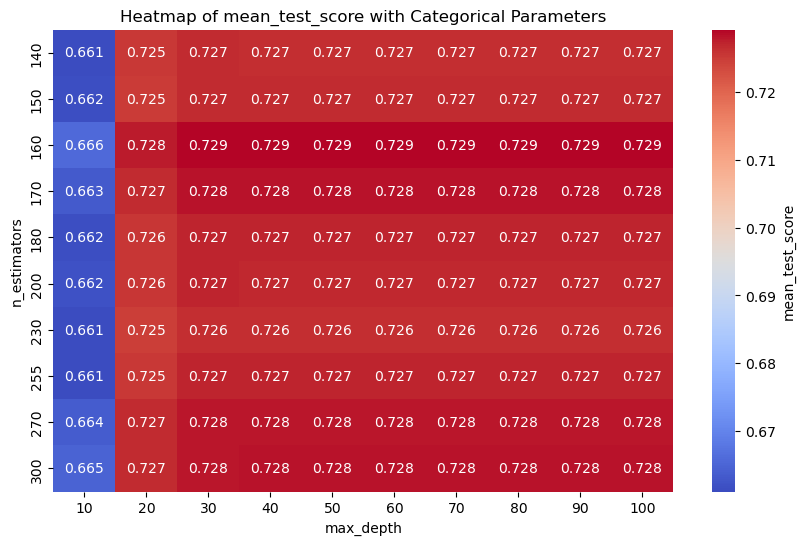

In [2]:

# Filter out the 'bootstrap' column
df_filtered = df.drop(columns=['bootstrap'])

# Reshape the data for creating a heatmap
heatmap_data = df_filtered.pivot_table(index=['n_estimators'], columns=['max_depth'], values='mean_test_score')

# Create a heatmap using seaborn with mean test values formatted to three digits
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='coolwarm', cbar_kws={'label': 'mean_test_score'})
plt.title('Heatmap of mean_test_score with Categorical Parameters')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import multiprocessing  # Import the multiprocessing library

from collections import OrderedDict
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import pickle

random.seed(100000)

# Loading Data

X1 = pd.read_csv("Data/parameters_subsample_sneasybrick.csv") 
# Read CSV files
X2 = pd.read_csv("Data/dvbm_s.csv")
X3 = pd.read_csv("Data/movefactor_s.csv")
X4 = pd.read_csv("Data/vslel_s.csv")
X5 = pd.read_csv("Data/vslmult_s.csv")
X6 = pd.read_csv("Data/wvel_s.csv")
X7 = pd.read_csv("Data/wvpdl_s.csv")

# Rename the columns
X2.rename(columns={X2.columns[0]: 'dvbm_s'}, inplace=True)
X3.rename(columns={X3.columns[0]: 'movefactor_s'}, inplace=True)
X4.rename(columns={X4.columns[0]: 'vslel_s'}, inplace=True)
X5.rename(columns={X5.columns[0]: 'vslmult_s'}, inplace=True)
X6.rename(columns={X6.columns[0]: 'wvel_s'}, inplace=True)
X7.rename(columns={X7.columns[0]: 'wvpdl_s'}, inplace=True)

X = pd.concat([X1, X2, X3, X4, X5, X6, X7], axis=1)

# Extracting Feature names
feature_names = X.columns

# Define the parameter grid with all the hyperparameters you want to tune
param_grid = { 
    "n_estimators": [140],
    "max_features": [8],
    "min_samples_split": [2],
    "max_depth": [5],
}

In [9]:
X.shape

(10000, 57)

In [2]:


# Create empty lists to collect data from all scenarios
all_top_feature_indices = []
all_top_feature_importances = []

# Define a function to process each scenario
def process_scenario(scenario_name):

   # Clear the lists at the beginning of each scenario
    all_top_feature_indices.clear()
    all_top_feature_importances.clear()

    # Loading Data

    # load the dataset as a pandas dataframe
    df = pd.read_csv(f"Data/NPVOptimal_Gulf_Sneasy_{scenario_name}.csv") 

    # Calculate the average of each column using the mean() function

    column_averages = df.sum()

    # convert the series to a dataframe with a single column
    Y = pd.DataFrame(column_averages, columns=['AverageNPVOptimalCost'])

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)

    # Standardizing the data.
    scaler = StandardScaler().fit(X_train[feature_names]) 

    X_train[feature_names] = scaler.transform(X_train[feature_names])
    X_test[feature_names] = scaler.transform(X_test[feature_names])

    # Creating test and train sets
    df_train = y_train.join(X_train)
    df_test = y_test.join(X_test)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    # Create the RandomForestRegressor with your chosen random_state
    reg = RandomForestRegressor(random_state=100)
    
    # Choose the scoring metric (Mean Squared Error)
    scoring = 'neg_mean_squared_error'

    # Perform the grid search with cross-validation
    CV5_reg = GridSearchCV(estimator=reg, param_grid=param_grid, scoring=scoring, cv=5)

    # Perform the grid search with cross-validation 
    CV5_reg.fit(X_train, y_train)

    # After fitting the GridSearchCV, you can access the results
    results = CV5_reg.cv_results_

    # Extract the mean test scores and parameters for all combinations
     
    mean_test_scores = results['mean_test_score']
    n_estimators = results['param_n_estimators']
    min_samples_split = results['param_min_samples_split']
    max_depth = results['param_max_depth']
    max_features = results['param_max_features']



    # Create a DataFrame
    result_df = pd.DataFrame({
        'mean_test_score': mean_test_scores,
        'n_estimators': n_estimators,
        'min_samples_split': min_samples_split,
        'max_depth': max_depth,
        'max_features': max_features
    })

    # Sort the DataFrame by 'mean_test_score' in descending order
    result_df_sorted = result_df.sort_values(by='mean_test_score', ascending=False)
    
    # Save the DataFrame to a CSV file
    result_df_sorted.to_csv(f"ParaTunning/ParaTunningFiles/NPVOptimal/ParaTunning_NPVOptimal_Gulf_{scenario_name}.csv", index=False)

    # Getting the best parameters
    best_params = CV5_reg.best_params_
    print(f"Best Parameters for NPVOptimalCost Gulf SSP_{scenario_name}:", best_params)
    
    return result_df_sorted

    
    
    
# Define a function to be executed in parallel
def parallel_execution(scenario_name):
    print(f"Processing {scenario_name}...")
    result_df = process_scenario(scenario_name)
    print(f"{scenario_name} processing completed.")
    return scenario_name, result_df

if __name__ == '__main__':
    # Define the scenarios to be processed
    scenarios = ["126", "245", "460", "585"]

    # Create a pool of worker processes
    num_tasks = 4  # Number of tasks to run in parallel
    pool = multiprocessing.Pool(processes=num_tasks)

    # Execute the scenarios in parallel
    results = pool.map(parallel_execution, scenarios)

    # Close the pool
    pool.close()
    pool.join()

    

    # Print a completion message
    print("All scenarios processed.")
    

Processing 126...Processing 460...Processing 245...Processing 585...





Best Parameters for NPVOptimalCost Gulf SSP_460: {'max_depth': 5, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 140}
460 processing completed.
Best Parameters for NPVOptimalCost Gulf SSP_245: {'max_depth': 5, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 140}
245 processing completed.
Best Parameters for NPVOptimalCost Gulf SSP_126: {'max_depth': 5, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 140}
126 processing completed.
Best Parameters for NPVOptimalCost Gulf SSP_585: {'max_depth': 5, 'max_features': 8, 'min_samples_split': 2, 'n_estimators': 140}
585 processing completed.
All scenarios processed.


In [11]:
import inspect
from sklearn.model_selection import GridSearchCV



In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import multiprocessing  # Import the multiprocessing library
import os

from collections import OrderedDict
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
import pickle

random.seed(100000)

# Loading Data

X1 = pd.read_csv("Data/parameters_subsample_sneasybrick.csv") 
# Read CSV files
X2 = pd.read_csv("Data/dvbm_s.csv")
X3 = pd.read_csv("Data/movefactor_s.csv")
X4 = pd.read_csv("Data/vslel_s.csv")
X5 = pd.read_csv("Data/vslmult_s.csv")
X6 = pd.read_csv("Data/wvel_s.csv")
X7 = pd.read_csv("Data/wvpdl_s.csv")

# Rename the columns
X2.rename(columns={X2.columns[0]: 'dvbm_s'}, inplace=True)
X3.rename(columns={X3.columns[0]: 'movefactor_s'}, inplace=True)
X4.rename(columns={X4.columns[0]: 'vslel_s'}, inplace=True)
X5.rename(columns={X5.columns[0]: 'vslmult_s'}, inplace=True)
X6.rename(columns={X6.columns[0]: 'wvel_s'}, inplace=True)
X7.rename(columns={X7.columns[0]: 'wvpdl_s'}, inplace=True)

X = pd.concat([X1, X2, X3, X4, X5, X6, X7], axis=1)

X.to_csv('Data/features.csv', index=False)

X.shape

(10000, 57)

In [2]:
X = pd.read_csv("Data/features.csv")


In [7]:
# load the dataset as a pandas dataframe
df = pd.read_csv(f"Data/NoAdaptCost_Gulf_2050_Sneasy_126.csv") 


In [8]:
df.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x9991,x9992,x9993,x9994,x9995,x9996,x9997,x9998,x9999,x10000
0,0.001999,0.001452,0.003487,0.004848,0.001805,0.001938,0.001845,0.001338,0.003084,0.002361,...,0.003410,0.001681,0.003301,0.001825,0.002331,0.001671,0.002916,0.001637,0.003541,0.001773
1,0.019634,0.012461,0.030137,0.039417,0.021350,0.026042,0.013093,0.009548,0.025514,0.017837,...,0.033101,0.017182,0.033308,0.019286,0.017002,0.013312,0.026487,0.021837,0.028917,0.023810
2,0.006480,0.004621,0.011841,0.017475,0.005402,0.005581,0.006354,0.004488,0.011029,0.008490,...,0.011294,0.005299,0.011217,0.005573,0.008653,0.005202,0.008929,0.004521,0.012074,0.005035
3,0.004654,0.003210,0.007954,0.011238,0.004355,0.004866,0.004003,0.002862,0.007145,0.005368,...,0.008001,0.003916,0.007957,0.004231,0.005335,0.003542,0.006392,0.004019,0.007943,0.004419
4,0.024928,0.017525,0.045238,0.066675,0.021164,0.022303,0.023890,0.016893,0.041924,0.031883,...,0.043603,0.020426,0.043341,0.021653,0.032481,0.019744,0.034475,0.018118,0.045983,0.020359


In [6]:
# Loop through each row in the dataset as Y
for row_index, row in df.iterrows():
    
    Y = row.to_frame()  # Convert the row to a DataFrame
    Y = Y.rename(columns={Y.columns[0]: 'AverageNoAdaptCost'}) 
    print(Y.head())

    AverageNoAdaptCost
x1            0.001999
x2            0.001452
x3            0.003487
x4            0.004848
x5            0.001805
    AverageNoAdaptCost
x1            0.019634
x2            0.012461
x3            0.030137
x4            0.039417
x5            0.021350
    AverageNoAdaptCost
x1            0.006480
x2            0.004621
x3            0.011841
x4            0.017475
x5            0.005402
    AverageNoAdaptCost
x1            0.004654
x2            0.003210
x3            0.007954
x4            0.011238
x5            0.004355
    AverageNoAdaptCost
x1            0.024928
x2            0.017525
x3            0.045238
x4            0.066675
x5            0.021164
    AverageNoAdaptCost
x1            0.040866
x2            0.031795
x3            0.050966
x4            0.049101
x5            0.050340
    AverageNoAdaptCost
x1            0.001859
x2            0.001357
x3            0.002801
x4            0.003391
x5            0.001985
    AverageNoAdaptCost
x1         

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import random
import multiprocessing  # Import the multiprocessing library

from collections import OrderedDict
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

random.seed(100000)

# Loading Data

X = pd.read_csv("Data/features.csv")

# Extracting Feature names
feature_names = X.columns

# Define the parameter grid with all the hyperparameters you want to tune
param_grid = { 
    "n_estimators": 420,
    "min_samples_split": 2,
    "max_depth": 3,
    "max_features": 37,
}


# Define a function to process each scenario
def process_scenario(scenario_name):

    # Loading Data

    # load the dataset as a pandas dataframe
    df = pd.read_csv(f"Data/NoAdaptCost_Gulf_2050_Sneasy_{scenario_name}.csv") 

    # Calculate the average of each column using the mean() function

    column_averages = df.sum()

    # convert the series to a dataframe with a single column
    Y = pd.DataFrame(column_averages, columns=['AverageNoAdaptCost'])

    # Splitting the data
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)

    # Standardizing the data.
    scaler = StandardScaler().fit(X_train[feature_names]) 

    X_train[feature_names] = scaler.transform(X_train[feature_names])
    X_test[feature_names] = scaler.transform(X_test[feature_names])

    # Creating test and train sets
    df_train = y_train.join(X_train)
    df_test = y_test.join(X_test)
    y_train = np.ravel(y_train)
    y_test = np.ravel(y_test)

    # Create the RandomForestRegressor with your chosen random_state
    reg = RandomForestRegressor(random_state=100)
    
    best_params = param_grid

    # Create the final model with the best parameters
    reg_cv5 = RandomForestRegressor(random_state=100, **best_params)
    reg_cv5.fit(X_train, y_train)

    # Predict on the training and test data
    pred = reg_cv5.predict(X_train)
    pred_test = reg_cv5.predict(X_test)

    # Obtaining feature importance
    feature_importance = reg_cv5.feature_importances_

    # Sorting features according to importance
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0])
    
    # Sort the feature importances and corresponding feature names
    sorted_features = np.array(feature_names)[sorted_idx][::-1]
    sorted_importances = feature_importance[sorted_idx][::-1]

    # Create a DataFrame containing the sorted feature names and importances
    importance_df = pd.DataFrame({'Feature': sorted_features, 'Importance': sorted_importances})

    # Define the file path where you want to save the CSV file
    csv_file_path = f'logs/FeatureImpFiles/NoAdapt2050/NoAdaptCost_Gulf_2050_{scenario_name}.csv'

    # Save the DataFrame to a CSV file
    importance_df.to_csv(csv_file_path, index=False)

    # Plotting feature importances
    plt.barh(pos, feature_importance[sorted_idx], align="center")

    plt.yticks(pos, np.array(feature_names)[sorted_idx], size =5)

    plt.title(f"FeatureImp NoAdaptCost Gulf 2050 {scenario_name}")
    plt.xlabel("Importance score")
    plt.savefig(f'logs/FeatureImpPlots/NoAdapt2050/NoAdaptCost_Gulf_2050_{scenario_name}.png')
    plt.close()



# Define a function to be executed in parallel
def parallel_execution(scenario_name):
    print(f"Processing {scenario_name}...")
    process_scenario(scenario_name)
    print(f"{scenario_name} processing completed.")

if __name__ == '__main__':
    # Define the scenarios to be processed
    scenarios = ["126", "245", "460", "585"]

    # Create a pool of worker processes
    num_tasks = 4  # Number of tasks to run in parallel
    pool = multiprocessing.Pool(processes=num_tasks)

    # Execute the scenarios in parallel
    pool.map(parallel_execution, scenarios)

    # Close the pool
    pool.close()
    pool.join()

    # Print a completion message
    print("All scenarios processed.")

Processing 126...Processing 460...Processing 245...Processing 585...





KeyboardInterrupt: 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
import random
import multiprocessing  # Import the multiprocessing library

from collections import OrderedDict
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

random.seed(100000)

# Loading Data

X = pd.read_csv("Data/features.csv")

# Extracting Feature names
feature_names = X.columns

# Define the parameter grid with all the hyperparameters you want to tune
param_grid = { 
    "n_estimators": 420,
    "min_samples_split": 2,
    "max_depth": 35,
    "max_features": 37,
}


# Define a function to process each scenario
def process_scenario(scenario_name, year):

    for year in np.range(2000, 2101, 10):

        # load the dataset as a pandas dataframe
        df = pd.read_csv(f"Data/OptimalCost_Gulf_{year}_Sneasy_{scenario_name}.csv") 

        # Calculate the average of each column using the mean() function

        column_averages = df.sum()

        # convert the series to a dataframe with a single column
        Y = pd.DataFrame(column_averages, columns=['AverageNoAdaptCost'])

        # Splitting the data
        X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)

        # Standardizing the data.
        scaler = StandardScaler().fit(X_train[feature_names]) 

        X_train[feature_names] = scaler.transform(X_train[feature_names])
        X_test[feature_names] = scaler.transform(X_test[feature_names])

        # Creating test and train sets
        df_train = y_train.join(X_train)
        df_test = y_test.join(X_test)
        y_train = np.ravel(y_train)
        y_test = np.ravel(y_test)

        # Create the RandomForestRegressor with your chosen random_state
        reg = RandomForestRegressor(random_state=100)
        
        best_params = param_grid

        # Create the final model with the best parameters
        reg_cv5 = RandomForestRegressor(random_state=100, **best_params)
        reg_cv5.fit(X_train, y_train)

        # Predict on the training and test data
        pred = reg_cv5.predict(X_train)
        pred_test = reg_cv5.predict(X_test)

        # Obtaining feature importance
        feature_importance = reg_cv5.feature_importances_

        # Sorting features according to importance
        sorted_idx = np.argsort(feature_importance)
        pos = np.arange(sorted_idx.shape[0])
        
        # Sort the feature importances and corresponding feature names
        sorted_features = np.array(feature_names)[sorted_idx][::-1]
        sorted_importances = feature_importance[sorted_idx][::-1]

        # Create a DataFrame containing the sorted feature names and importances
        importance_df = pd.DataFrame({'Feature': sorted_features, 'Importance': sorted_importances})
        
        folder_path = f'logs/FeatureImpFiles/OptimalCost{year}/'
        
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Define the file path where you want to save the CSV file
        csv_file_path = f'{folder_path}/OptimalCost_Gulf_{year}_{scenario_name}.csv'

        # Save the DataFrame to a CSV file
        importance_df.to_csv(csv_file_path, index=False)



# Define a function to be executed in parallel
def parallel_execution(scenario_name):
    print(f"Processing {scenario_name}...")
    process_scenario(scenario_name)
    print(f"{scenario_name} processing completed.")

if __name__ == '__main__':
    # Define the scenarios to be processed
    scenarios = ["126", "245", "460", "585"]

    # Create a pool of worker processes
    num_tasks = 4  # Number of tasks to run in parallel
    pool = multiprocessing.Pool(processes=num_tasks)

    # Execute the scenarios in parallel
    pool.map(parallel_execution, scenarios)

    # Close the pool
    pool.close()
    pool.join()

    # Print a completion message
    print("All scenarios processed.")


Processing 585...Processing 245...Processing 460...
Processing 126...




TypeError: process_scenario() missing 1 required positional argument: 'year'

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import multiprocessing  # Import the multiprocessing library

from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

random.seed(100000)

# Loading Data

X = pd.read_csv("Data/features.csv")

# Extracting Feature names
feature_names = X.columns

# Define the parameter grid with all the hyperparameters you want to tune
param_grid = { 
    "n_estimators": 420,
    "min_samples_split": 2,
    "max_depth": 3,
    "max_features": 37,
}


# load the dataset as a pandas dataframe
df = pd.read_csv(f"sneasy_files/OptimalCost_Gulf_2050_Sneasy_585.csv") 

# Calculate the average of each column using the mean() function

column_averages = df.sum()

# convert the series to a dataframe with a single column
Y = pd.DataFrame(column_averages, columns=['AverageOptimalCost'])

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=40)

# Standardizing the data.
scaler = StandardScaler().fit(X_train[feature_names]) 

X_train[feature_names] = scaler.transform(X_train[feature_names])
X_test[feature_names] = scaler.transform(X_test[feature_names])

# Creating test and train sets
df_train = y_train.join(X_train)
df_test = y_test.join(X_test)
y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

best_params = param_grid

# Create the final model with the best parameters
reg_cv5 = RandomForestRegressor(random_state=100, **best_params)
reg_cv5.fit(X_train, y_train)



585 processing completed.
126 processing completed.
460 processing completed.
245 processing completed.


In [ ]:
estimator = rf.estimators_[0]

# Step 4: Visualize the extracted tree
plt.figure(figsize=(20,10))
tree.plot_tree(estimator, filled=True, feature_names=['Feature1', 'Feature2', 'Feature3', 'Feature4'], class_names=True)
plt.title("Visualized Decision Tree from Random Forest")
plt.show()